# Nerual Network for Binary Classification of IPO Underpricing

### References
[PyTorch - Binary Classification](https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89)

[PyTorch for deep learning binary classification logistic regression](https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('../data/clean_bloomberg_with_sectors.csv')

<AxesSubplot:xlabel='Underpriced', ylabel='count'>

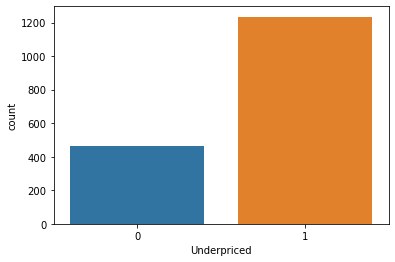

In [3]:
sns.countplot(x = 'Underpriced', data=data)

In [4]:
ipo_labels = data['Underpriced'].tolist()
ipo_features = data._get_numeric_data().columns.values.tolist()[1:-1]
ipo_features.remove('Offer To 1st Close')
x = data[ipo_features]
y = torch.tensor(data.loc[:, 'Underpriced'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=351)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [6]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(torch.FloatTensor(X_train), y_train)

## test data    
class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

test_data = TestData(torch.FloatTensor(X_test))

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [8]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=14, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### Train Model

In [12]:
model.train()
losses = []
accur = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred, y_batch.unsqueeze(1).float())
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        loss =  epoch_loss/len(train_loader)
        acc = epoch_acc/len(train_loader)
                               
    losses.append(loss)
    accur.append(acc)
    print ("epoch: {:<3} | loss: {:<6.5f} | accuracy: {:<10.5f}".format(e, loss, acc))

epoch: 1   | loss: 0.68938 | accuracy: 55.36842  
epoch: 2   | loss: 0.62536 | accuracy: 66.78947  
epoch: 3   | loss: 0.59850 | accuracy: 72.00000  
epoch: 4   | loss: 0.57067 | accuracy: 73.78947  
epoch: 5   | loss: 0.56270 | accuracy: 73.57895  
epoch: 6   | loss: 0.54762 | accuracy: 73.78947  
epoch: 7   | loss: 0.52353 | accuracy: 75.78947  
epoch: 8   | loss: 0.51354 | accuracy: 75.57895  
epoch: 9   | loss: 0.50718 | accuracy: 76.89474  
epoch: 10  | loss: 0.48963 | accuracy: 76.47368  
epoch: 11  | loss: 0.48701 | accuracy: 77.21053  
epoch: 12  | loss: 0.48503 | accuracy: 77.15789  
epoch: 13  | loss: 0.47758 | accuracy: 77.47368  
epoch: 14  | loss: 0.47420 | accuracy: 77.63158  
epoch: 15  | loss: 0.46168 | accuracy: 78.15789  
epoch: 16  | loss: 0.45640 | accuracy: 78.89474  
epoch: 17  | loss: 0.45537 | accuracy: 78.21053  
epoch: 18  | loss: 0.45777 | accuracy: 79.05263  
epoch: 19  | loss: 0.45502 | accuracy: 78.21053  
epoch: 20  | loss: 0.44725 | accuracy: 79.78947  


### Test Model

In [13]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Accuracy 

In [14]:
correct = 0
len(y_pred_list)
for i in range(510):
    if y_test.tolist()[i] == y_pred_list[i]:
        correct += 1
print("Accurary: ", correct / 510)
print(classification_report(y_test, y_pred_list))

Accurary:  0.6882352941176471
              precision    recall  f1-score   support

           0       0.40      0.15      0.22       148
           1       0.72      0.91      0.81       362

    accuracy                           0.69       510
   macro avg       0.56      0.53      0.51       510
weighted avg       0.63      0.69      0.63       510



### Loss vs Epochs Graph

Text(0, 0.5, 'loss')

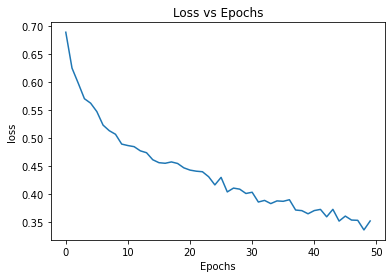

In [15]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

### Accuracy vs Epochs

Text(0, 0.5, 'loss')

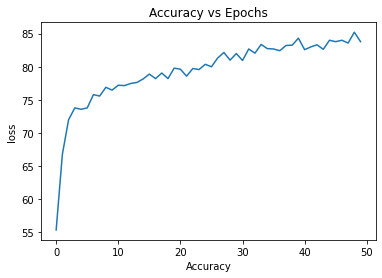

In [16]:
#printing the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [ ]:
# save the model
torch.save(model.state_dict(), 'saved_models/binary_classification.pt')